In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRD, DataXRF, SpectraXRD, FastSpectraXRD, GaussNewton, PhaseList,
                         PhaseMap, PhaseSearch, PhaseMapSave, GammaMap, ChiMap)
from os.path import isdir
from os import makedirs

from numpy import flip, array, ones_like

from matplotlib.pyplot import (sca, vlines, show, fill_between, legend, imshow, subplots, plot, xlim, ylim, xlabel,
                               ylabel, cm, title, scatter, colorbar, figure, rcParams)
from PIL import Image


def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

# General choices

In [2]:
path_xrd = '../../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/' # XRD scan
path_xrf = '../../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRF/' # XRF scan
path_database = '../../../shared/Database/' # tabulated phases

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

sigma = 0.2
min_theta = 20
max_theta = 58
min_intensity = 0.05 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
k_b = None

In [3]:
# rcParams.update({
# "text.usetex": False,
# "font.family": "DejaVu Sans",
# "font.sans-serif": ["Helvetica"]})

In [4]:
rcParams.update({
'image.origin': 'lower'
})

#### Check if output folders exist. If not, create them.

In [5]:
if not isdir(path_data):
    makedirs(path_data)
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)

# Read XRD scan

In [6]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Cannot read from h5 data. Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')

print(f'Shape of data: {data.shape}')
print(f'Calibration parameters: a = {data.opt[0]:.3f}, s = {data.opt[1]:.3f}, beta = {data.opt[2]:.3f}')

Loading: ../../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
Shape of data: (188, 140, 1280)
Calibration parameters: a = -1172.774, s = 2053.102, beta = 50.710


### Display integrated data
This is only to check. For each pixel, shows the integrated signal.

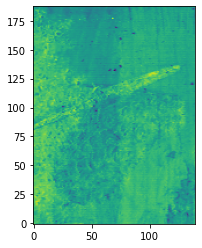

In [7]:
figure()
im = imshow(data.data.sum(axis=2))
show()

# Read database

In [8]:
database = DatabaseXRD().read_cifs(path_database)
print(f'Phases in database: {len(database)}')

Phases in database: 144


### Explore phase database
See the phases in the database that contain all of the chosen elements. For each phase we see:

mineral name (when available), chemical formula, number of samples in the database

In [9]:
elements_chosen = ['Fe']

for key in sorted(database.keys()):
    pl = database[key]
    p = pl[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(pl))

Akaganeite, 	Cl0.675 Fe4 O8, 	2
Erythrite, 	As4 Co4.02 Fe1.48 H32 Ni0.50 O32, 	1
Fe H O2, 	1
Fe2 Mn O4, 	4
Fe2 O3, 	12
Goethite, 	Fe H O2, 	21
Hematite, 	Fe2 O3, 	10
Jacobsite, 	Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017, 	4
Jarosite, 	Fe2.88 H5.83 K0.81 O13.64 S2, 	15
Lepidocrocite, 	Fe H O2, 	2
Magnetite, 	Fe3 O4, 	1
Pyrite, 	Fe S2, 	9
Siderite, 	C Fe O3, 	2
Wuestite, 	Fe0.911 O, 	11


### Define Phases
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [10]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]
gold = database['Gold'][0]
hematite = database['Hematite'][4]

# Check selected phases in a given point

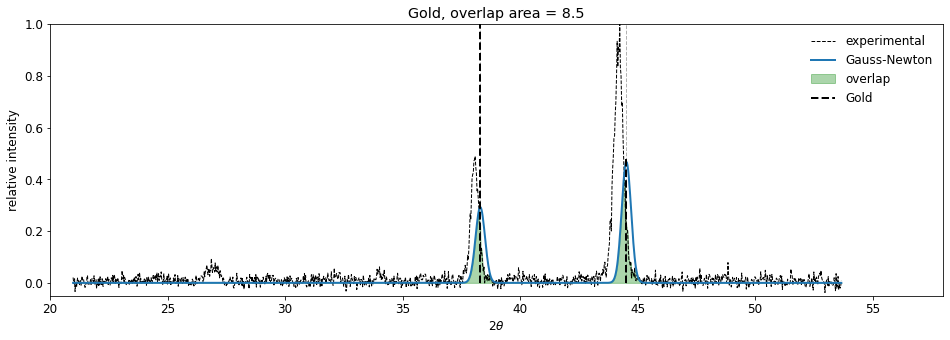

In [11]:
%matplotlib inline
rcParams['font.size'] = 12

x, y = 81, 116
#phases_sel = PhaseList([hydrocerussite, gold, lazurite])
#phases_sel = PhaseList([gold, lazurite])
phases_sel = gold

gn = GaussNewton(phases_sel, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
#gn.fit_cycle(gamma = True, max_steps = 16).fit_cycle(a = True, s = True, gamma = True, max_steps = 16).fit_cycle(gamma = True, max_steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)

gn.plot_spectrum(c = 'black', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'tab:blue', ls = '-', lw = 2, label = f'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'green', alpha = 0.33, label='overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2, alpha = 1)

ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'$2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap_area():.1f}')
legend(frameon = False)
show()

In [12]:
provola = gn.make_phases()

In [11]:
%%time

phases_for_calibration = PhaseList([hydrocerussite, cinnabar, lazurite, gold, hematite])
print(f'Selected phases: {[phase.label for phase in phases_for_calibration]}')

gmap = GammaMap().from_data(data, phases_for_calibration, sigma = sigma, min_theta = min_theta,
                            max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

Selected phases: ['Hydrocerussite', 'Cinnabar', 'Lazurite', 'Gold', 'Hematite']
CPU times: user 1 s, sys: 90.7 ms, total: 1.09 s
Wall time: 1.09 s


In [21]:
def select_phases(self, criterion, offset = -8):
    phases_new = []

    for idx in range(len(self.phases)):
        point = criterion[:, :, idx].flatten().argsort()[offset]
        gauss_newton = self[point][idx]
        phases_made = gauss_newton.make_phases()
        for phase in phases_made:
            phase['name'] = 'created_%d'%idx
            phase['point'] = point
            phases_new += [phase]

    return PhaseList(phases_new)

GammaMap.select_phases = select_phases

In [22]:
criterion = ones_like(data.data)
provola = gmap.select_phases(criterion = criterion)

In [23]:
type(provola)

XRDXRFutils.database.PhaseList

In [24]:
len(provola)

5

In [25]:
for phase in provola:
    print(f'{phase.label}: {phase.get_theta()}')
    #print(phase)

Hydrocerussite: (array([22.50784557, 24.69207474, 27.18665762, 32.99260178, 34.04367108,
       34.18152332, 36.0777548 , 36.19593856, 39.86414036, 40.42823653,
       41.31519951, 42.6228012 , 43.04402736, 44.21036078, 45.94818269,
       46.65457004, 48.24071298, 49.014125  , 50.63459111, 53.49961695]), array([3.6000e-04, 7.4861e-01, 1.0000e+00, 8.7320e-02, 3.4109e-01,
       5.3856e-01, 9.2770e-02, 3.5000e-04, 1.3580e-02, 2.4343e-01,
       5.8000e-04, 1.4858e-01, 1.8136e-01, 1.8249e-01, 3.8100e-03,
       1.6720e-02, 1.2698e-01, 2.9295e-01, 4.0000e-04, 3.9800e-03]))
Cinnabar: (array([24.77313157, 26.51331315, 28.15070761, 31.19598604, 43.62074332,
       45.75881859, 47.82875599, 51.77486834, 52.72567416]), array([0.     , 0.76186, 0.219  , 1.     , 0.37672, 0.32453, 0.     ,
       0.11862, 0.2239 ]))
Lazurite: (array([21.82760084, 23.94038756, 27.71266427, 31.06153655, 34.11266972,
       35.55105242, 36.94060171, 39.59383671, 40.86588343, 42.10609553,
       44.50189334, 45.6620

# Fit with tabulated phases

Finds the best calibration in each site using selected phases.

Then, adjusts the peaks.

In [13]:
phases_for_calibration = PhaseList([hydrocerussite, cinnabar, lazurite, gold, hematite])
print(f'Selected phases: {[phase.label for phase in phases_for_calibration]}')

Selected phases: ['Hydrocerussite', 'Cinnabar', 'Lazurite', 'Gold', 'Hematite']


In [14]:
%%time
gmap = GammaMap().from_data(data, phases_for_calibration, sigma = sigma, min_theta = min_theta,
                            max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

CPU times: user 1.05 s, sys: 94.5 ms, total: 1.14 s
Wall time: 1.14 s


In [16]:
%%time
gmap = gmap.search()

CPU times: user 8.45 s, sys: 1.56 s, total: 10 s
Wall time: 12min 8s
